In [318]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import ks_2samp
from scipy.stats import pearsonr
import plotly.figure_factory as ff
# from plotnine import *
# from pyecharts.charts import Map
# from pyecharts import options
%matplotlib inline


In [319]:
# plt.style.use('fivethirtyeight')
plt.style.use('ggplot')

In [320]:
# df = pd.read_excel('../../data/爬取的数据.xlsx', sheet_name='非二手帆船')
# df = pd.read_excel('../../data/爬取的数据_copy.xlsx', sheet_name='非二手帆船')
df = pd.read_excel('../../data/包含区域信息.xlsx', index_col=0)

In [321]:
df_backup = df.copy()

In [322]:
df = df_backup.copy()

In [323]:
df.head(1)

,Link,Price-1,Basics.Location,New,Basics.Year,Basics.Make,Basics.Model,Basics.Class,Basics.Length,Basics.FuelType,...,Features.InsideEquipment.Seakeeper,Features.InsideEquipment.AirCompressor,Specifications.Speed&Distance.Range,Features.OutsideEquipment.WindGenerator,Specifications.Dimensions.Freeboard,Specifications.Miscellaneous.LiferaftCapacity,Propulsion.RopeCutter,Specifications.Miscellaneous.DeadriseAtTransom,Features.AdditionalEquipment.LaunchingTrailer,Features.AdditionalEquipment.BeachingLegs
0,https://www.yachtworld.com/yacht/2023-jeanneau...,329795.0,"Seattle, Washington, United States",True,2023.0,Jeanneau,380,Cruiser,38ft,Diesel,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [324]:
df.info() # 有113个 object需要处理。  一共2188个条目。

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12457 entries, 0 to 12456
Columns: 128 entries, Link to Features.AdditionalEquipment.BeachingLegs
dtypes: bool(1), float64(12), object(115)
memory usage: 12.2+ MB


In [325]:
df.columns # 太多了，分开处理 124
basics_columns = list(filter(lambda x:x.startswith('Basics'), df.columns))
propulsion_columns = list(filter(lambda x:x.startswith('Propulsion'), df.columns))
specification_columns = list(filter(lambda x:x.startswith('Specification'), df.columns))
feature_columns = list(filter(lambda x:x.startswith('Feature'), df.columns))

list(map(len, (basics_columns, propulsion_columns, specification_columns, feature_columns)))
price_column = ['Price']
df[price_column].describe()

,Price
count,1.127800e+04
mean,4.430823e+05
std,1.230341e+06
min,1.240000e+02
25%,6.390000e+04
50%,1.627950e+05
75%,4.250000e+05
max,4.897202e+07


In [326]:
# basics_columns.pop(0)

## 针对 Basics进行处理

In [327]:
appropriate_types = {'定类':str, '定序':int, '定距':float, '定比':float}
appropriate_operation = {'定类':'mode', '定序':'median', '定距':'mean', '定比':'mean'}

In [328]:
should_be = ['定类', '定距', '定类', '定类', '定类', '定比', '定类', '定类', '定类',  '定比', '定类']
should_be = list(map(lambda x: appropriate_types[x], should_be))
basics_columns, should_be

(['Basics.Location',
  'Basics.Year',
  'Basics.Make',
  'Basics.Model',
  'Basics.Class',
  'Basics.Length',
  'Basics.FuelType',
  'Basics.HullMaterial',
  'Basics.HullShape',
  'Basics.HullWarranty',
  'Basics.OfferedBy'],
 [str, float, str, str, str, float, str, str, str, float, str])

In [329]:
def len_tran(x):
    if pd.isna(x): return None
    
    # assert x.endswith('ft')
    # return float(x[:-2])
    return float(x.split('ft')[0])
df['Basics.Length'] = df['Basics.Length'].map(len_tran)
df=df.rename(columns={'Basics.Length':'Basics.Length (ft)'})

In [330]:
# df[['Basics.Length', 'Basics.HullWarranty']].tail()
df[['Basics.Length (ft)', 'Basics.HullWarranty']].tail()
# df[['Basics.Length (ft)', 'Basics.HullWarranty (years)']].tail()

,Basics.Length (ft),Basics.HullWarranty
12452,32.00,NaN
12453,28.00,NaN
12454,28.00,NaN
12455,25.00,NaN
12456,14.92,NaN


In [331]:
'1'.split(' ')[0]
'1 year'.split(' ')[0]
'1 years'.split(' ')[0]

'1'

In [332]:
df=df.rename(columns={'Basics.HullWarranty':'Basics.HullWarranty (years)'})

def war_tran(x):
    x = str(x)
    if x=='nan':
        # return x
        return 0 # 用0填充保险值。
    num = x.split(' ')[0]
    return float(num)
df['Basics.HullWarranty (years)'] = df['Basics.HullWarranty (years)'].map(war_tran)
# df['Basics.HullWarranty (years)'].fillna(0, inplace=True)

In [333]:
df[['Basics.Model', 'Basics.FuelType', 'Basics.HullShape']].value_counts()

Basics.Model     Basics.FuelType  Basics.HullShape
42               Diesel           Catamaran           60
40               Diesel           Catamaran           41
34               Diesel           Monohull            36
46               Diesel           Catamaran           35
Sun Odyssey 440  Diesel           Monohull            34
                                                      ..
72               Diesel           Catamaran            1
70 Sail          Diesel           Catamaran            1
70 B             Diesel           Monohull             1
70               Diesel           Catamaran            1
xp44             Diesel           Monohull             1
Length: 1964, dtype: int64

In [334]:
# df[df['Basics.Model'].isnull()]
# df['Basics.Model'] = df['Basics.Model'].dropna()
df = df.dropna(subset=['Basics.Model']) # dropna是一个整体操作

In [335]:
df['Make-Model'] = df['Basics.Make'] + '-' + df['Basics.Model']
# group = df.groupby(['Basics.Make', 'Basics.Model'])

grouper = 'Make-Model'
group = df.groupby(grouper)


In [336]:
datalen = []
for k, v in group:
    # print(k)
    # print(len(v))
    datalen.append(len(v))
    # print(v['Basics.HullShape'].value_counts())
    # print()
# plt.hist(datalen, bins=30)

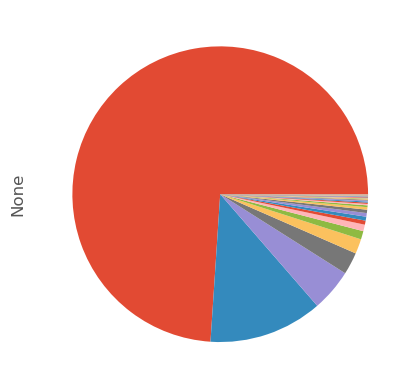

In [337]:
pd.Series(datalen).astype(str).value_counts().plot.pie()

plt.savefig('make-model.png')

In [338]:
cols = ['Basics.Location', 'Basics.FuelType', 'Basics.HullShape'] # 要填充的列
# group_mode = group[cols].agg(lambda x:{x.name: x.mode()} if not  x.isna().sum()==len(x) else None) # 用众数填充
group_mode = group[cols].agg(lambda x:x.mode().sample(frac=1).to_numpy()[0] if not  x.isna().sum()==len(x) else None) # 用众数填充
# group_mode = group[cols].mode()
group_mode
full_mode = df[cols].mode() # 用全局众数填充
full_mode


,Basics.Location,Basics.FuelType,Basics.HullShape
0,"San Diego, California, United States",Diesel,Monohull


In [339]:
# a = group_mode.to_numpy()
# d = {k:v for }
group_mode.loc['A-Yachts-A-33', 'Basics.FuelType']

'Diesel'

In [340]:
def fill_each_row(x, col):
    # print(x[0] if pd.isna(x[0]) else None)
    return group_mode.loc[x[0], col] if pd.isna(x[1]) else x[1]
    
for col in ['Basics.Location', 'Basics.FuelType', 'Basics.HullShape']:
    df[col] = df[['Make-Model', col]].apply(lambda x:fill_each_row(x, col), axis=1)
    df[col] = df[col].fillna(df[col].mode()[0])

In [341]:
# for k, v in group:
#     if len(v)>=5:
#         # 使用组内操作
#         for col in cols:
#             # df[col] = df[col].fillna(df[col].mode())
#             v[col].fillna(v[col].mode(), inplace=True)
#     else:
#         # 使用整个列表的填充
#         for col in cols:
#             # df[col] = df[col].fillna(df[col].mode())
#             v[col].fillna(df[col].mode(), inplace=True)
# # if df[col].isnull().sum()==len(v):
            # #     raise
            # # df[col] = df[col].fillna(v[col].mode())
            # v[col].fillna(v[col].mode(), inplace=True)
            # 想把v内缺失的值填充为组内的众数，但是为什么没能修改原来的df呢？
            # v[col] = v[col].fillna(v[col].mode())

In [342]:
# df[['Basics.Model', 'Basics.FuelType', 'Basics.HullShape']].tail()
df[['Basics.Model', 'Basics.FuelType', 'Basics.HullShape']].describe()

,Basics.Model,Basics.FuelType,Basics.HullShape
count,12389,12389,12389
unique,4846,5,11
top,40,Diesel,Monohull
freq,161,11449,9951


In [343]:
basics_columns = list(filter(lambda x:x.startswith('Basics'), df.columns))

In [344]:
df[basics_columns].isnull().sum()

Basics.Location                0
Basics.Year                    0
Basics.Make                    0
Basics.Model                   0
Basics.Class                   0
Basics.Length (ft)             0
Basics.FuelType                0
Basics.HullMaterial            0
Basics.HullShape               0
Basics.HullWarranty (years)    0
Basics.OfferedBy               0
dtype: int64

In [345]:
for col, typ in zip(basics_columns, should_be):
    df[col] = df[col].astype(typ)

In [346]:
df[basics_columns].dtypes

Basics.Location                 object
Basics.Year                    float64
Basics.Make                     object
Basics.Model                    object
Basics.Class                    object
Basics.Length (ft)             float64
Basics.FuelType                 object
Basics.HullMaterial             object
Basics.HullShape                object
Basics.HullWarranty (years)    float64
Basics.OfferedBy                object
dtype: object

In [347]:
print(df)

                                                    Link   Price-1  \
0      https://www.yachtworld.com/yacht/2023-jeanneau...  329795.0   
1      https://www.yachtworld.com/yacht/2023-dufour-3...  364999.0   
2      https://www.yachtworld.com/yacht/2023-bavaria-...  432319.0   
3      https://www.yachtworld.com/yacht/1984-union-po...   31000.0   
4      https://www.yachtworld.com/yacht/2023-dufour-4...  850000.0   
...                                                  ...       ...   
12452  https://www.yachtworld.com/yacht/1995-catalina...   54000.0   
12453  https://www.yachtworld.com/yacht/1997-beneteau...   36000.0   
12454  https://www.yachtworld.com/yacht/1978-southern...   25000.0   
12455  https://www.yachtworld.com/yacht/1980-cape-dor...    9500.0   
12456  https://www.yachtworld.com/yacht/1988-test-mon...     124.0   

                             Basics.Location    New  Basics.Year  \
0         Seattle, Washington, United States   True       2023.0   
1           Racine, Wis

## 针对propulsion进行处理

In [348]:
should_be = np.array(['定类', '定类', '定距', '定比',  '定比', '定类', '定类',   '定类', '定序', '定类', '定序', '定序'])
should_be_type = list(map(lambda x: appropriate_types[x], should_be))
assert len(propulsion_columns) == len(should_be_type)
propulsion_columns, should_be_type

(['Propulsion.EngineMake',
  'Propulsion.EngineModel',
  'Propulsion.EngineYear',
  'Propulsion.TotalPower',
  'Propulsion.EngineHours',
  'Propulsion.EngineType',
  'Propulsion.DriveType',
  'Propulsion.FuelType',
  'Propulsion.PropellerType',
  'Propulsion.PropellerMaterial',
  'Propulsion.FoldingPropeller',
  'Propulsion.RopeCutter'],
 [str, str, float, float, float, str, str, str, int, str, int, int])

In [349]:
should_be_dict = dict(zip(propulsion_columns, should_be))
prop_discrete_cols = list(filter(lambda x: should_be_dict[x]=='定类' or should_be_dict[x]=='定序', propulsion_columns))
prop_discrete_cols

['Propulsion.EngineMake',
 'Propulsion.EngineModel',
 'Propulsion.EngineType',
 'Propulsion.DriveType',
 'Propulsion.FuelType',
 'Propulsion.PropellerType',
 'Propulsion.PropellerMaterial',
 'Propulsion.FoldingPropeller',
 'Propulsion.RopeCutter']

In [350]:
df[propulsion_columns].dtypes

Propulsion.EngineMake            object
Propulsion.EngineModel           object
Propulsion.EngineYear           float64
Propulsion.TotalPower            object
Propulsion.EngineHours          float64
Propulsion.EngineType            object
Propulsion.DriveType             object
Propulsion.FuelType              object
Propulsion.PropellerType         object
Propulsion.PropellerMaterial     object
Propulsion.FoldingPropeller      object
Propulsion.RopeCutter            object
dtype: object

In [351]:
col = 'Propulsion.PropellerType'
df[col].unique()

def tran(x):
    x = str(x)
    if x=='nan' or x=='folding':
        return np.nan
    return float(x.split(' ')[0])
df[col] = df[col].map(tran)

In [352]:
cols = ['Propulsion.FoldingPropeller', 'Propulsion.RopeCutter']
df[cols].describe()
# df[cols[0]].unique()
# df[cols[1]].unique()

def tran(x):
    x = str(x)
    if x=='nan':
        return False
    return True
for col in cols:
    df[col] = df[col].map(tran)

In [353]:
df=df.rename(columns={'Propulsion.TotalPower':'Propulsion.TotalPower (hp)'})

def war_tran(x):
    x = str(x)
    if x=='nan':
        # return x
        return np.nan
    num = x.split('hp')[0]
    return float(num)
df['Propulsion.TotalPower (hp)'] = df['Propulsion.TotalPower (hp)'].map(war_tran)
# df['Basics.HullWarranty (years)'].fillna(0, inplace=True)

In [354]:
# # df[propulsion_columns].describe()
# # df[prop_discrete_cols].value_counts()
# df[prop_discrete_cols]
# df['Propulsion.PropellerMaterial'].value_counts()
# # df['Propulsion.PropellerMaterial'].isna()   
# df['Propulsion.PropellerMaterial'].head(20)
# df['Propulsion.PropellerMaterial'].mode()
# df['Propulsion.PropellerMaterial'].fillna(df['Propulsion.PropellerMaterial'].mode()[0], inplace=True)

In [355]:
propulsion_columns = list(filter(lambda x:x.startswith('Propulsion'), df.columns))
should_be_dict = dict(zip(propulsion_columns, should_be))
grouper = 'Make-Model'
group = df.groupby(grouper)

In [360]:
df[propulsion_columns].isna().sum(), prop_discrete_cols


(Propulsion.EngineMake           0
 Propulsion.EngineModel          0
 Propulsion.EngineYear           0
 Propulsion.TotalPower (hp)      0
 Propulsion.EngineHours          0
 Propulsion.EngineType           0
 Propulsion.DriveType            0
 Propulsion.FuelType             0
 Propulsion.PropellerType        0
 Propulsion.PropellerMaterial    0
 Propulsion.FoldingPropeller     0
 Propulsion.RopeCutter           0
 dtype: int64,
 ['Propulsion.EngineMake',
  'Propulsion.EngineModel',
  'Propulsion.EngineType',
  'Propulsion.DriveType',
  'Propulsion.FuelType',
  'Propulsion.PropellerType',
  'Propulsion.PropellerMaterial',
  'Propulsion.FoldingPropeller',
  'Propulsion.RopeCutter'])

In [357]:
def full_and_group_mode(col):
    group_mode = group[col].agg(lambda x:x.mode().sample(frac=1).to_numpy()[0] if not  x.isna().sum()==len(x) else None) # 用众数填充
    # group_mode = group[cols].mode()
    full_mode = df[col].mode().sample(frac=1).to_numpy()[0] # 用全局众数填充； 随机选取众数中的一个
    
    return group_mode, full_mode
# full_and_group_mode('Propulsion.EngineMake')[1]    
def full_and_group_median(col):
    # 求解 col 这一列的组中位数和全局中位数
    group_median = group[col].agg(lambda x:x.median()if not  x.isna().sum()==len(x) else None) 
    full_median = df[col].median() 
    return group_median, full_median

def full_and_group_mean(col):
    # 求解 col 这一列的组均值和全局均值
    group_mean = group[col].agg(lambda x:x.mean()if not  x.isna().sum()==len(x) else None) 
    full_mean = df[col].mean() 
    return group_mean, full_mean
    
op_dict = {'mode':full_and_group_mode, 'median':full_and_group_median, 'mean':full_and_group_mean}

In [358]:
for col in propulsion_columns:
    sh = should_be_dict[col]
    op = appropriate_operation[sh]
    print(f"正在使用{op}填充{col}")
    op = op_dict[op]
    group_stat, full_stat = op(col)


    def fill_each_row(x):
        # print(x[0] if pd.isna(x[0]) else None)
        return group_stat.loc[x[0]] if pd.isna(x[1]) else x[1]
        
    df[col] = df[['Make-Model', col]].apply(lambda x:fill_each_row(x), axis=1)
    print(full_stat)
    df[col].fillna(full_stat, inplace=True)

正在使用mode填充Propulsion.EngineMake
Yanmar
正在使用mode填充Propulsion.EngineModel
3YM30
正在使用mean填充Propulsion.EngineYear
2006.0593591315005
正在使用mean填充Propulsion.TotalPower (hp)
77.5745186773504
正在使用mean填充Propulsion.EngineHours
1756.5644317641465
正在使用mode填充Propulsion.EngineType
Inboard
正在使用mode填充Propulsion.DriveType
Direct Drive
正在使用mode填充Propulsion.FuelType
Diesel
正在使用median填充Propulsion.PropellerType
3.0
正在使用mode填充Propulsion.PropellerMaterial
Bronze
正在使用median填充Propulsion.FoldingPropeller
0.0
正在使用median填充Propulsion.RopeCutter
0.0


In [359]:
df['Propulsion.TotalPower (hp)'] = df['Propulsion.TotalPower (hp)'].astype(str)

## 针对 Specification 进行处理

In [361]:
raw_order = ['Specifications.Dimensions.LengthOverall (ft)',
  'Specifications.Dimensions.Beam (ft)',
  'Specifications.Accommodations.DoubleBerths',
  'Specifications.Accommodations.Cabins',
  'Specifications.Accommodations.Heads',
  'Specifications.Speed&Distance.CruisingSpeed (kn)',
  'Specifications.Speed&Distance.MaxSpeed (kn)',
  'Specifications.Dimensions.LengthOnDeck (ft)',
  'Specifications.Dimensions.MaxDraft (ft)',
  'Specifications.Dimensions.CabinHeadroom (ft)',
  'Specifications.Dimensions.LengthAtWaterline (ft)',
  'Specifications.Miscellaneous.Windlass',
  'Specifications.Dimensions.MaxBridgeClearance (ft)',
  'Specifications.Weights.DryWeight (Lb)',
  'Specifications.Accommodations.SingleBerths',
  'Specifications.Accommodations.TwinBerths',
  'Specifications.Miscellaneous.ElectricalCircuit (V)',
  'Specifications.Miscellaneous.SeatingCapacity',
  'Specifications.Speed&Distance.Range (nm)',
  'Specifications.Dimensions.Freeboard (ft)',
  'Specifications.Miscellaneous.LiferaftCapacity',
  'Specifications.Miscellaneous.DeadriseAtTransom (deg)']
raw_order_without_单位 = [col.split(' (')[0] for col in raw_order]
should_be = np.array(['定比','定比',
                      '定距','定距',
                      '定距','定比',
                      '定比','定比',
                      '定比','定比',
                      '定比','定类',
                      '定比','定比',
                      '定距','定距',
                      '定比','定距',
                      '定比','定比',
                      '定距','定比'])
should_be_col = dict(zip(raw_order_without_单位, should_be))
should_be_col

{'Specifications.Dimensions.LengthOverall': '定比',
 'Specifications.Dimensions.Beam': '定比',
 'Specifications.Accommodations.DoubleBerths': '定距',
 'Specifications.Accommodations.Cabins': '定距',
 'Specifications.Accommodations.Heads': '定距',
 'Specifications.Speed&Distance.CruisingSpeed': '定比',
 'Specifications.Speed&Distance.MaxSpeed': '定比',
 'Specifications.Dimensions.LengthOnDeck': '定比',
 'Specifications.Dimensions.MaxDraft': '定比',
 'Specifications.Dimensions.CabinHeadroom': '定比',
 'Specifications.Dimensions.LengthAtWaterline': '定比',
 'Specifications.Miscellaneous.Windlass': '定类',
 'Specifications.Dimensions.MaxBridgeClearance': '定比',
 'Specifications.Weights.DryWeight': '定比',
 'Specifications.Accommodations.SingleBerths': '定距',
 'Specifications.Accommodations.TwinBerths': '定距',
 'Specifications.Miscellaneous.ElectricalCircuit': '定比',
 'Specifications.Miscellaneous.SeatingCapacity': '定距',
 'Specifications.Speed&Distance.Range': '定比',
 'Specifications.Dimensions.Freeboard': '定比',
 'Specif

In [362]:
df = df.drop(['Specifications.Tanks.FuelTank'], axis=1)

In [363]:
df = df.drop(['Specifications.Tanks.FreshWaterTank'], axis=1)

In [364]:

df = df.drop(['Specifications.Tanks.HoldingTank'], axis=1)

In [376]:
specification_columns = list(filter(lambda x:x.startswith('Specification'), df.columns))
grouper = 'Make-Model'
group = df.groupby(grouper)

In [366]:
should_be = [should_be_col[col] for col in specification_columns]
should_be

['定比',
 '定比',
 '定比',
 '定比',
 '定距',
 '定距',
 '定距',
 '定距',
 '定比',
 '定比',
 '定比',
 '定比',
 '定比',
 '定类',
 '定距',
 '定比',
 '定距',
 '定比',
 '定比',
 '定比',
 '定距',
 '定比']

In [373]:
should_be_type = list(map(lambda x: appropriate_types[x], should_be))
assert len(specification_columns) == len(should_be_type)
specification_columns, should_be_type


(['Specifications.Dimensions.LengthOverall (ft)',
  'Specifications.Dimensions.MaxDraft (ft)',
  'Specifications.Dimensions.Beam (ft)',
  'Specifications.Dimensions.LengthAtWaterline (ft)',
  'Specifications.Accommodations.SingleBerths',
  'Specifications.Accommodations.DoubleBerths',
  'Specifications.Accommodations.Cabins',
  'Specifications.Accommodations.Heads',
  'Specifications.Weights.DryWeight (Lb)',
  'Specifications.Speed&Distance.CruisingSpeed (kn)',
  'Specifications.Speed&Distance.MaxSpeed (kn)',
  'Specifications.Dimensions.LengthOnDeck (ft)',
  'Specifications.Dimensions.CabinHeadroom (ft)',
  'Specifications.Miscellaneous.Windlass',
  'Specifications.Accommodations.TwinBerths',
  'Specifications.Miscellaneous.ElectricalCircuit (V)',
  'Specifications.Miscellaneous.SeatingCapacity',
  'Specifications.Dimensions.MaxBridgeClearance (ft)',
  'Specifications.Speed&Distance.Range (nm)',
  'Specifications.Dimensions.Freeboard (ft)',
  'Specifications.Miscellaneous.LiferaftCapa

In [368]:
单位批量处理_cols = [i for i in raw_order if i.endswith(')')]
单位批量处理_cols

['Specifications.Dimensions.LengthOverall (ft)',
 'Specifications.Dimensions.Beam (ft)',
 'Specifications.Speed&Distance.CruisingSpeed (kn)',
 'Specifications.Speed&Distance.MaxSpeed (kn)',
 'Specifications.Dimensions.LengthOnDeck (ft)',
 'Specifications.Dimensions.MaxDraft (ft)',
 'Specifications.Dimensions.CabinHeadroom (ft)',
 'Specifications.Dimensions.LengthAtWaterline (ft)',
 'Specifications.Dimensions.MaxBridgeClearance (ft)',
 'Specifications.Weights.DryWeight (Lb)',
 'Specifications.Miscellaneous.ElectricalCircuit (V)',
 'Specifications.Speed&Distance.Range (nm)',
 'Specifications.Dimensions.Freeboard (ft)',
 'Specifications.Miscellaneous.DeadriseAtTransom (deg)']

In [377]:
# df['Specifications.Dimensions.MaxDra']
# 单位批量处理_cols[5]  = 'Specifications.Dimensions.MaxDraft (ft)'

In [378]:
# df['Specifications.Dimensions.MaxDraft']

In [371]:
def general_trans(x):
    if pd.isna(x): return np.nan
    x = str(x)
    if x=='none': return np.nan
    num = ''.join(filter(str.isdigit, x))
    try:
        return float(num)
    except Exception as e:
        print(x)
        raise e
general_trans('1')
general_trans('1fp')
general_trans('1 fp')
general_trans('1 year')
general_trans('12,2,3 year')
general_trans(np.nan)

for col in 单位批量处理_cols:
    print(f"正在处理{col.split(' (')[0]}")
    df=df.rename(columns={col.split(' (')[0]: col})
    df[col] = df[col].map(general_trans)
    
    # df=df.rename(columns={col: [i for i in raw_order if i.startswith(col)][0] })

正在处理Specifications.Dimensions.LengthOverall
正在处理Specifications.Dimensions.Beam
正在处理Specifications.Speed&Distance.CruisingSpeed
正在处理Specifications.Speed&Distance.MaxSpeed
正在处理Specifications.Dimensions.LengthOnDeck
正在处理Specifications.Dimensions.MaxDraft
正在处理Specifications.Dimensions.CabinHeadroom
正在处理Specifications.Dimensions.LengthAtWaterline
正在处理Specifications.Dimensions.MaxBridgeClearance
正在处理Specifications.Weights.DryWeight
正在处理Specifications.Miscellaneous.ElectricalCircuit
正在处理Specifications.Speed&Distance.Range
正在处理Specifications.Dimensions.Freeboard
正在处理Specifications.Miscellaneous.DeadriseAtTransom


In [374]:
should_be_dict = dict(zip(specification_columns, should_be))
spec_discrete_cols = list(filter(lambda x: should_be_dict[x]=='定类' or should_be_dict[x]=='定序', specification_columns))
spec_discrete_cols

['Specifications.Miscellaneous.Windlass']

In [37]:
# df[spec_discrete_cols[0]].unique()
# df[specification_columns].describe()
# print(df[spec_discrete_cols].to_numpy())
# df[spec_discrete_cols].to_csv('spec_discrete_cols_temp.csv', index=False)

In [379]:
for col in specification_columns:
    sh = should_be_dict[col]
    op = appropriate_operation[sh]
    print(f"正在使用{op}填充{col}")
    op = op_dict[op]
    group_stat, full_stat = op(col)


    def fill_each_row(x):
        # print(x[0] if pd.isna(x[0]) else None)
        return group_stat.loc[x[0]] if pd.isna(x[1]) else x[1]
        
    df[col] = df[['Make-Model', col]].apply(lambda x:fill_each_row(x), axis=1)
    print(full_stat)
    df[col].fillna(full_stat, inplace=True)

正在使用mean填充Specifications.Dimensions.LengthOverall (ft)
328849.37397034594
正在使用mean填充Specifications.Dimensions.MaxDraft (ft)
267507.0754216612
正在使用mean填充Specifications.Dimensions.Beam (ft)
187279.32472204056
正在使用mean填充Specifications.Dimensions.LengthAtWaterline (ft)
286749.6687451286
正在使用mean填充Specifications.Accommodations.SingleBerths
3.1790558871405317
正在使用mean填充Specifications.Accommodations.DoubleBerths
2.582379196584514
正在使用mean填充Specifications.Accommodations.Cabins
2.8856447688564475
正在使用mean填充Specifications.Accommodations.Heads
2.0216310751104567
正在使用mean填充Specifications.Weights.DryWeight (Lb)
2633846.1823074333
正在使用mean填充Specifications.Speed&Distance.CruisingSpeed (kn)
15527.947598253275
正在使用mean填充Specifications.Speed&Distance.MaxSpeed (kn)
20201.682953311618
正在使用mean填充Specifications.Dimensions.LengthOnDeck (ft)
295487.2566371681
正在使用mean填充Specifications.Dimensions.CabinHeadroom (ft)
79396.09993906155
正在使用mode填充Specifications.Miscellaneous.Windlass
Electric Windlass
正在使用mean填充Spe

In [380]:
df[specification_columns].isna().sum()

Specifications.Dimensions.LengthOverall (ft)            0
Specifications.Dimensions.MaxDraft (ft)                 0
Specifications.Dimensions.Beam (ft)                     0
Specifications.Dimensions.LengthAtWaterline (ft)        0
Specifications.Accommodations.SingleBerths              0
Specifications.Accommodations.DoubleBerths              0
Specifications.Accommodations.Cabins                    0
Specifications.Accommodations.Heads                     0
Specifications.Weights.DryWeight (Lb)                   0
Specifications.Speed&Distance.CruisingSpeed (kn)        0
Specifications.Speed&Distance.MaxSpeed (kn)             0
Specifications.Dimensions.LengthOnDeck (ft)             0
Specifications.Dimensions.CabinHeadroom (ft)            0
Specifications.Miscellaneous.Windlass                   0
Specifications.Accommodations.TwinBerths                0
Specifications.Miscellaneous.ElectricalCircuit (V)      0
Specifications.Miscellaneous.SeatingCapacity            0
Specifications

## 针对Feature进行处理

In [381]:
# should_be = np.array(['定比','定比',
                    #   '定距','定距',
                    #   '定距','定比',
                    #   '定比','定比',
                    #   '定比','定比',
                    #   '定比','定类',
                    #   '定比','定比',
                    #   '定距','定距',
                    #   '定比','定距',
                    #   '定比','定比',
                    #   '定距','定比'])
# should_be_type = list(map(lambda x: appropriate_types[x], should_be))
# assert len(specification_columns) == len(should_be_type)
# feature_columns, should_be_type
feature_columns


['Features.ElectricalEquipment.ShorePowerInlet',
 'Features.Electronics.Depthsounder',
 'Features.Electronics.Log-speedometer',
 'Features.Electronics.WindSpeedAndDirection',
 'Features.Electronics.Repeater(s)',
 'Features.Electronics.Plotter',
 'Features.Electronics.Autopilot',
 'Features.Electronics.Radio',
 'Features.Electronics.Compas',
 'Features.Electronics.Gps',
 'Features.Electronics.CockpitSpeakers',
 'Features.Electronics.Vhf',
 'Features.InsideEquipment.BowThruster',
 'Features.InsideEquipment.ElectricBilgePump',
 'Features.InsideEquipment.Oven',
 'Features.InsideEquipment.ManualBilgePump',
 'Features.InsideEquipment.MicrowaveOven',
 'Features.InsideEquipment.AirConditioning',
 'Features.InsideEquipment.ElectricHead',
 'Features.InsideEquipment.Heating',
 'Features.InsideEquipment.HotWater',
 'Features.InsideEquipment.Refrigerator',
 'Features.InsideEquipment.BatteryCharger',
 'Features.OutsideEquipment.CockpitShower',
 'Features.OutsideEquipment.CockpitCushions',
 'Features

In [382]:
df[feature_columns].dtypes
df[feature_columns].to_excel('feature_cols_temp.xlsx', index=False)
# print(df[feature_columns].describe())
# df[feature_columns].describe().to_csv('feature_cols_temp.csv')

In [383]:
def tran(x):
    if pd.isna(x):
        return False
    return True
df[feature_columns] = df[feature_columns].applymap(tran)

In [384]:
pd.isna(df[feature_columns].iloc[2, 0])

False

In [385]:
# pd.isna(df.loc[2, 1])
pd.isna(None)
pd.isna(np.nan)

True

In [386]:
df[feature_columns].isna().sum().any()

False

In [387]:
# df.isna().sum().any()
s = df.isna().sum()
s[s>0]

Price-1    1150
Price      1150
dtype: int64

In [49]:
df['Price'].to_excel('price_temp.xlsx', index=False)
# .to_csv('price_temp.csv', index=False)

In [50]:
df.dropna().to_excel("../../data/包含区域信息_cleaned.xlsx", index=False)